# Algoritmos Genéticos - Tutorial de programación
Vamos a desarrollar un algoritmo genético para resolver el problema de la mochila (Knapsack problem). Para ello usaremos una codificación de cadena de bits (indicando si el objeto de cada posición de la cadena se añade o no a la mochila).

# Números (pseudo)aleatorios
Al usar números aleatorios, se puede definir una semilla (seed), que permite que la generación de números aleatorios sea siempre la misma al repetir la ejecución del algoritmo. Esta dará reproducibilidad al algoritmo genético, permitiendo repetir el experimento con los mismos números aleatorios y obteniendo así el mismo resultado.

Cuando se desarrolla un algoritmo genético, y en general para cualquier algoritmo estocástico, se suele ejecutar múltiples veces el experimento con distintas semillas y luego se saca la media y desviación típica de los resultados (fitness). Una buena práctica es realizar un mínimo de 30 ejecuciones del algoritmo con distintas semillas, lo cual asegurará la significatividad estadística de los resultados.

In [1]:
import numpy as np
np.random.seed(1234567890)

# Definición del problema de la mochila
Vamos a definir la representación del problema de la mochila mediante cadenas/arrays de bits, donde el 1 indica que se guarda el objeto. Las cadenas tendrán un tamaño fijo igual al número de objetos y usarán el mismo alfabeto para todos los genes.

Para definir la función de fitness primeramente comprueba si el peso de la mochila ha sido sobrepasado, en cuyo caso devuelve 0. Si no, realizará una suma de los valores de los objetos que se consideran en la solución del cromosoma pasado como argumento.

In [2]:
alphabet = [0,1]

def knapsack_fitness(chromosome, *args, **kwargs):
    fitness = 0
    weights=kwargs['weights'] # kwargs almacena un diccionario con argumentos nominales extra
    values=kwargs['values']
    max_weight =kwargs['max_weight']
    if np.dot(weights, chromosome) <= max_weight:
        fitness = np.dot(values, chromosome)
    return fitness

# Definición de los operadores genéticos
Definimos una función para generar un individuo aleatorio en base a la longitud del cromosoma y a los valores del alfabeto.

In [3]:
def generate_random_individual(alphabet, length, *args, **kwargs):
    indices = np.random.randint(0, len(alphabet), length)
    return np.array(alphabet)[indices]

Definimos la función de selección usando el método de la ruleta (Roulette Wheel Selection), en el cual usamos las probabilidades calculadas a partir de la fitness para elegir de una pasada todos los padres que se usarán para la fase de reproducción. Esta función solo funcionará correctamente si las fitness es de maximización y tiene valores positivos.

In [4]:
def roulette_wheel_selection(population, fitness, number_parents, *args, **kwargs):
    population_fitness = sum(fitness)
    chromosome_probabilities = [f/population_fitness for f in fitness]
    indices = np.random.choice(range(len(fitness)), number_parents, p=chromosome_probabilities)
    return [population[i] for i in indices]

Definimos el operador de cruce de un punto, que en base a la probabilidad de cruce decidira si se cruza. En caso afirmativo, se elige un punto de corte aleatorio entre 1 y L-1, y partimos e intercambiamos los cromosomas de los padres a partir de ese punto. Esta función solo será válida para padres de igual longitud.

In [5]:
def one_point_crossover(parent1, parent2, p_cross, *args, **kwargs):
    if np.random.random() < p_cross:
        point = np.random.randint(1,len(parent1)-1)
        child1 = np.append(parent1[:point],parent2[point:])
        child2 = np.append(parent2[:point],parent1[point:])
        return child1, child2
    else:
        return parent1, parent2

Definimos el operador de mutación uniforme, que selecciona una máscara de posiciones a mutar en base a la probabilidad pmut, y selecciona nuevos valores aleatorios del alfabeto para dichas posiciones de la máscara.

In [6]:
def uniform_mutation(chromosome, p_mut, alphabet, *args, **kwargs):
    child = np.copy(chromosome)
    random_values = np.random.random(len(chromosome))
    mask = random_values < p_mut
    indices = np.random.randint(0, len(alphabet), size=np.count_nonzero(mask))
    child[mask] = np.array(alphabet)[indices]
    return child

Definimos el criterio de parada básico, que terminará la ejecución cuando se haya alcanzado un número concreto de generaciones.

In [7]:
def generation_stop(generation, fitness, best_fitness, mean_fitness, *args, **kwargs):
    max_gen=kwargs['max_gen']
    return generation >= max_gen

# Definición del algoritmo genético
A continuación se implementa el algoritmo genético. Este algoritmo solo funcionará con cadenas de tamaño fijo en la que todos los genes usen el mismo alfabeto y usando el reemplazo como selección ambiental.
El algoritmo deberá recibir el alfabeto a usar, la longitud del cromosoma, el tamaño de la población, las funciones para generar individuos, calcular la fitness, el criterio de parada, la selección parental, el cruce y la mutación, así como las probabilidades de cruce y mutación y el tamaño del elitismo.
Después del proceso evolutivo, el algoritmo devolverá el mejor individuo encontrado y su valor de fitness, la generación en la que se ha acabado y la fitness mejor y media obtenida en cada generación.

In [8]:
import math

def genetic_algorithm(alphabet, length, pop_size, generate_individual, fitness, stopping_criteria, elitism, selection, crossover, p_cross, mutation, p_mut, *args, **kwargs):
    # Population initialization
    population = [generate_individual(alphabet, length, *args, **kwargs) for _ in range(pop_size)]
    offspring_size = pop_size - elitism
    generation = 0
    best_fitness = []
    mean_fitness = []

    # First fitness evaluation
    fitness_values = [fitness(x, *args, **kwargs) for x in population]
    best_fitness.append(np.max(fitness_values))
    mean_fitness.append(np.mean(fitness_values))

    # Main loop, checking stopping criteria
    while not stopping_criteria(generation, fitness_values, best_fitness, mean_fitness, *args, **kwargs):

        # Select elite parents
        if elitism > 0:
            indices = np.argpartition(fitness_values, -elitism)[-elitism:]
            elite = [population[i] for i in indices]

        # Select the parents and perform crossover and mutation
        parents = selection(population, fitness_values, offspring_size if (offspring_size%2==0) else offspring_size+1, *args, **kwargs)
        offspring = []
        for k in range(math.ceil(offspring_size/2)):
            parent1 = parents[2*k]
            parent2 = parents[2*k+1]
            child1, child2 = crossover(parent1, parent2, p_cross, *args, **kwargs)
            child1 = mutation(child1, p_mut, alphabet, *args, **kwargs)
            offspring.append(child1)
            if 2*k+1 < offspring_size:
                child2 = mutation(child2, p_mut, alphabet, *args, **kwargs)
                offspring.append(child2)

        # Build new population (replacing)
        if elitism > 0:
            population[:elitism] = elite
            population[elitism:] = offspring

        # Compute fitness of new population
        fitness_values = [fitness(x, *args, **kwargs) for x in population]
        best_fitness.append(np.max(fitness_values))
        mean_fitness.append(np.mean(fitness_values))
        generation += 1

    # Get the fittest individual
    fittest_index = np.where(fitness_values == np.max(fitness_values))[0][0]
    fittest_individual = population[fittest_index]
    fittest_fitness = fitness_values[fittest_index]

    return fittest_individual, fittest_fitness, generation, best_fitness, mean_fitness

# Creación de un ejemplo de prueba
Definimos a continuación un problema de la mochila con 50 objetos.

In [9]:
# Problem definition
length = 50
values = [360, 83, 59, 130, 431, 67, 230, 52, 93, 125, 670, 892, 600, 38, 48, 147,
          78, 256, 63, 17, 120, 164, 432, 35, 92, 110, 22, 42, 50, 323, 514, 28,
          87, 73, 78, 15, 26, 78, 210, 36, 85, 189, 274, 43, 33, 10, 19, 389, 276,
          312]
weights = [7, 0, 30, 22, 80, 94, 11, 81, 70, 64, 59, 18, 0, 36, 3, 8, 15, 42, 9, 0,
            42, 47, 52, 32, 26, 48, 55, 6, 29, 84, 2, 4, 18, 56, 7, 29, 93, 44, 71,
            3, 86, 66, 31, 65, 0, 79, 20, 65, 52, 13]
max_weight = 850

# Ejecución del algoritmo genético para el problema de la mochila
A continuación se ejecuta el algoritmo genético para el problema de la mochila durante un número de generaciones fijado y se muestran los resultados obtenidos.
Para comprobar como ha evolucionado el proceso de convergencia del algoritmo genético, representamos en una gráfica tanto la mejor fitness como la fitness media durante las generaciones que se realizaron.

Best Individual:
[1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1 1 0 1 0 0
 0 1 1 0 0 1 0 1 0 0 1 1 1]

Best Individual's Fitness:7466

Evolution:


Text(510.4494949494949, 0.5, 'Mean Fitness')

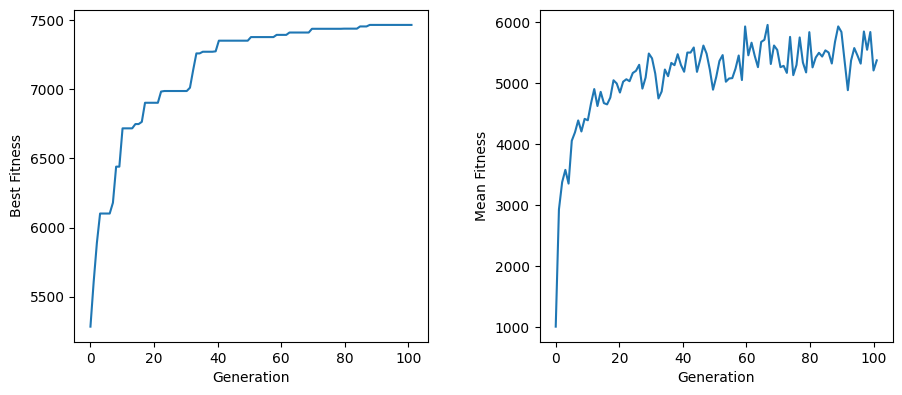

In [10]:
# Parameter initialization
pop_size = 100
elitism = 10
generations = 100
p_cross = 1.0
p_mut = 0.05

fittest_individual, fittest_fitness, generation, best_fitness, mean_fitness = genetic_algorithm(alphabet, length, pop_size, generate_random_individual, knapsack_fitness, generation_stop, elitism, roulette_wheel_selection, one_point_crossover, p_cross, uniform_mutation, p_mut, weights=weights, values=values, max_weight=max_weight, max_gen=generations)

print("Best Individual:")
print(fittest_individual)
print("\nBest Individual's Fitness:" + str(fittest_fitness))


print("\nEvolution:")

import matplotlib.pyplot as plt
x = np.linspace(0, generations+1, generations+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.tight_layout(pad=5.0)
ax1.plot(x, best_fitness)
ax2.plot(x, mean_fitness)
ax1.set_xlabel('Generation')
ax1.set_ylabel('Best Fitness')
ax2.set_xlabel('Generation')
ax2.set_ylabel('Mean Fitness')

# Evaluación de la calidad
Para evaluar la calidad del algoritmo, dada su naturaleza estocástica, debemos ejecutar múltiples veces con distintas semillas (>30 veces) y sacar la media de la mejor fitness (MBF).

In [11]:
from statistics import mean, stdev

n_ex = 31
fitness_ex = []
for i in range(n_ex):
    np.random.seed(1234567890 + i*23)
    _, fittest_fitness, _, _, _ = genetic_algorithm(alphabet, length, pop_size, generate_random_individual, knapsack_fitness, generation_stop, elitism, roulette_wheel_selection, one_point_crossover, p_cross, uniform_mutation, p_mut, weights=weights, values=values, max_weight=max_weight, max_gen=generations)
    fitness_ex.append(fittest_fitness)

print("MBF: " + str(mean(fitness_ex)) + " " + u"\u00B1" + " " + str(stdev([int(x) for x in fitness_ex])))


MBF: 7451 ± 46.723644172208814


# Ejercicios

## Ejercicio 1
Implementar los métodos de selección *selección por torneo* (con su parámetro extra T) y *selección de rango* (con su parámetro extra p), así como un método de criterio de parada que considere el estancamiento de la fitness.

Prueba el algoritmo genético para el problema de la mochila con las distintas combinaciones de operadores e hiperparámetros y encuentra la mejor combinación en términos de la MBF.

## Ejercicio 2
Define e implementa otra función de fitness diferente para el problema de la mochila que tenga en cuenta también las soluciones que no cumplen la restricción.

Prueba el algoritmo genético para el problema de la mochila con esta nueva fitness y compara qué fitness es mejor en términos de la MBF.

## Ejercicio 3
Implementa y resolver utilizando un algoritmo evolutivo el problema de empaquetamiento (Bin packing problem), en el cuál hay que asignar varios objetos de diferente peso a cajas de un peso máximo específico,intentando minimizar el número de cajas utilizadas para almacenar todos los objetos.

In [12]:
# Problem definition
length = 52
weights = [50, 50, 35, 35, 34, 34, 34, 33, 33, 33, 32, 31, 31, 30, 30, 29, 28,
           28, 28, 27, 26, 26, 26, 26, 25, 25, 22, 22, 21, 20, 18, 18, 16, 16,
           16, 16, 16, 13, 13, 13, 12, 11, 11, 10, 10, 9, 9, 7, 7, 7, 7, 5]
bin_weight = 50